# Deep Q-Network (DQN)
---
In this notebook, you will implement a DQN agent with OpenAI Gym's LunarLander-v2 environment.

### 1. Import the Necessary Packages

In [1]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

EXPERIMENT_NAME   = "rainbow"
EXPERIMENT_DETAIL = "DeepPartialLessNoise(02)"

### 2. Instantiate the Environment and Agent

Initialize the environment in the code cell below.

In [2]:
env = gym.make('LunarLander-v2')
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


Before running the next code cell, familiarize yourself with the code in **Step 2** and **Step 3** of this notebook, along with the code in `dqn_agent.py` and `model.py`.  Once you have an understanding of how the different files work together, 
- Define a neural network architecture in `model.py` that maps states to action values.  This file is mostly empty - it's up to you to define your own deep Q-network!
- Finish the `learn` method in the `Agent` class in `dqn_agent.py`.  The sampled batch of experience tuples is already provided for you; you need only use the local and target Q-networks to compute the loss, before taking a step towards minimizing the loss.

Once you have completed the code in `dqn_agent.py` and `model.py`, run the code cell below.  (_If you end up needing to make multiple changes and get unexpected behavior, please restart the kernel and run the cells from the beginning of the notebook!_)

You can find the solution files, along with saved model weights for a trained agent, in the `solution/` folder.  (_Note that there are many ways to solve this exercise, and the "solution" is just one way of approaching the problem, to yield a trained agent._)

In [3]:
# Hyperparameters

hyperparams = {
    'seed':                101,
    'buffer_size':         100000,
    'batch_size':          64,
    'start_since':         8000,
    'gamma':               0.99,
    'target_update_every': 6400,
    'tau':                 1,
    'lr':                  1e-4,
    'weight_decay':        0,
    'update_every':        4,
    'priority_eps':        1e-5,
    'a':                   0.5,
    'n_multisteps':        3,
    'v_min':               -300,
    'v_max':               300,
    'clip':                None,
    'n_atoms':             51,
    'initial_sigma':       0.02,
    'linear_type':         'noisy'
}

# Training Parameters

train_params = {
    'n_episodes': 2000, 'max_t':    500,
    'eps_start':  0.,   'eps_end':  0.,  'eps_decay': 0.,
    'beta_start': 0.4,   'beta_end': 1.0
}

In [4]:
from dqn_agent import Agent

agent = Agent(state_size=8, action_size=4, **hyperparams)

agent.qnetwork_local

QNetwork(
  (h0): Linear(in_features=8, out_features=256, bias=True)
  (h1): Linear(in_features=256, out_features=256, bias=True)
  (fc0): NoisyLinear(in_features=256, out_features=256, bias=True)
  (fc1_s): NoisyLinear(in_features=256, out_features=128, bias=True)
  (fc1_a): NoisyLinear(in_features=256, out_features=128, bias=True)
  (fc2_s): NoisyLinear(in_features=128, out_features=51, bias=True)
  (fc2_a): NoisyLinear(in_features=128, out_features=204, bias=True)
  (hidden_activation): ReLU()
)

### 3. Train the Agent with DQN

Run the code cell below to train the agent from scratch.  You are welcome to amend the supplied values of the parameters in the function, to try to see if you can get better performance!

Priority Used
Episode  100 | Total Steps:    6724 | Current Score: -520.97 | Average Score: -545.57 | Epsilon: 0.0000 | A: 0.5000 | Beta: 0.4300 | ANM: 0.0200 +- 0.0000          
Episode  200 | Total Steps:   18136 | Current Score: -414.57 | Average Score: -290.11 | Epsilon: 0.0000 | A: 0.5000 | Beta: 0.4600 | ANM: 0.0179 +- 0.0053          
Episode  300 | Total Steps:   67352 | Current Score:   -2.38 | Average Score:  -31.80 | Epsilon: 0.0000 | A: 0.5000 | Beta: 0.4900 | ANM: 0.0142 +- 0.0101          
Episode  400 | Total Steps:  114916 | Current Score:  119.26 | Average Score:   32.58 | Epsilon: 0.0000 | A: 0.5000 | Beta: 0.5200 | ANM: 0.0140 +- 0.0111          
Episode  500 | Total Steps:  161526 | Current Score:  228.47 | Average Score:  103.37 | Epsilon: 0.0000 | A: 0.5000 | Beta: 0.5500 | ANM: 0.0138 +- 0.0112          
Episode  600 | Total Steps:  203513 | Current Score:  139.16 | Average Score:  129.98 | Epsilon: 0.0000 | A: 0.5000 | Beta: 0.5800 | ANM: 0.0140 +- 0.0115       

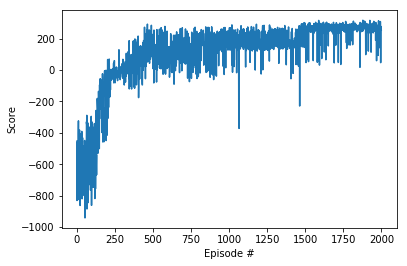

In [5]:
def dqn(n_episodes=2000, max_t=1000,
        eps_start=1.0, eps_end=0.01, eps_decay=0.995,
        beta_start=0., beta_end=1.0,
        continue_after_solved=True,
        save_name="checkpoint_dueling_solved.pth"):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    
    prioritized = hasattr(agent, 'beta')  # if using prioritized experience replay, initialize beta
    if prioritized:
        print("Priority Used")
        agent.beta = beta_start
        beta_increment = (beta_end - beta_start) / n_episodes
    else:
        print("Priority Not Used")
    
    noisy_params = [param for name, param in agent.qnetwork_local.named_parameters() if name.endswith('noisy_weight') or name.endswith('noisy_bias')]
        
    solved = False
    epi_str_max_len = len(str(n_episodes))
    n_steps_taken = 0
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        else: # if not done (reached max_t)
            agent.memory.reset_multisteps()
        n_steps_taken += t + 1
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        if prioritized:
            agent.beta = min(beta_end, agent.beta + beta_increment)
        report_str = "\rEpisode {:>{epi_max_len}d} | Total Steps: {:>7d} | Current Score: {:>7.2f} | Average Score: {:>7.2f} | Epsilon: {:>6.4f}"\
                     .format(i_episode, n_steps_taken, score, np.mean(scores_window), eps, epi_max_len=epi_str_max_len)
        if prioritized:
            report_str += " | A: {:>6.4f} | Beta: {:>6.4f}".format(agent.a, agent.beta)
        if noisy_params:
            flattened_abs_noise = np.concatenate([param.data.abs().cpu().numpy().reshape((-1,)) for param in noisy_params])
            report_str += " | ANM: {:>6.4f} +- {:<6.4f}".format(np.mean(flattened_abs_noise), np.std(flattened_abs_noise))
        report_str += "          "
        if i_episode % 100 == 0:
            report_str += '\n'
        print(report_str, end="")
        if not solved and np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), save_name)
            solved = True
            if not continue_after_solved:
                break
    return scores

scores = dqn(**train_params,
             continue_after_solved=True,
             save_name="experiment_{}_{}_solved.pth".format(EXPERIMENT_NAME, EXPERIMENT_DETAIL))

# plot the scores
plt.rcParams['figure.facecolor'] = 'w'
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [7]:
torch.save(agent.qnetwork_local.state_dict(), 'experiment_{}_{}_final.pth'.format(EXPERIMENT_NAME, EXPERIMENT_DETAIL))

In [8]:
agent.qnetwork_local.load_state_dict(torch.load('experiment_{}_{}_final.pth'.format(EXPERIMENT_NAME, EXPERIMENT_DETAIL)))

### 4. Watch a Smart Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent!

In [9]:
agent.qnetwork_local.noise(False)

for i in range(5):
    state = env.reset()
    score = 0
    for j in range(1000):
        action = agent.act(state)
        env.render()
        state, reward, done, _ = env.step(action)
        score += reward
        if done:
            break
    print("Game {} Score: {} in {} steps".format(i, score, j + 1))

agent.qnetwork_local.noise(True)
env.close()

Game 0 Score: 254.57978107081232 in 177 steps
Game 1 Score: 293.8996404800779 in 153 steps
Game 2 Score: 259.49639802819814 in 167 steps
Game 3 Score: 273.4929385098034 in 182 steps
Game 4 Score: 259.45027226649967 in 195 steps


### 5. Explore

In this exercise, you have implemented a DQN agent and demonstrated how to use it to solve an OpenAI Gym environment.  To continue your learning, you are encouraged to complete any (or all!) of the following tasks:
- Amend the various hyperparameters and network architecture to see if you can get your agent to solve the environment faster.  Once you build intuition for the hyperparameters that work well with this environment, try solving a different OpenAI Gym task with discrete actions!
- You may like to implement some improvements such as prioritized experience replay, Double DQN, or Dueling DQN! 
- Write a blog post explaining the intuition behind the DQN algorithm and demonstrating how to use it to solve an RL environment of your choosing.  

In [10]:
def reset_env():
    state = torch.from_numpy(env.reset()).unsqueeze(0).cuda()
    with torch.no_grad():
        p = agent.qnetwork_local(state).softmax(dim=-1)
        action = np.argmax(agent.supports.mul(p).sum(dim=-1, keepdim=False).cpu().numpy())
        env.render()

    p = p.cpu().squeeze().numpy()
    supports = agent.supports.cpu().numpy()
    plt.rcParams['figure.facecolor'] = 'w'
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    for ax in axes.reshape(-1):
        ax.grid(True)
        ax.set_ylabel("estimated probability")
        ax.set_xlabel("supports")
    axes[0, 0].set_title("do nothing")
    axes[0, 1].set_title("left engine")
    axes[1, 0].set_title("main engine")
    axes[1, 1].set_title("right engine")
    axes[0, 0].bar(x=supports, height=p[0], width=5)
    axes[0, 1].bar(x=supports, height=p[1], width=5)
    axes[1, 0].bar(x=supports, height=p[2], width=5)
    axes[1, 1].bar(x=supports, height=p[3], width=5)
    plt.tight_layout()
    
    return action

In [11]:
def step(action, n_steps):
    print(['nothing', 'left', 'main', 'right'][action])
    score_gained = 0
    for _ in range(n_steps):
        state, reward, done, _ = env.step(action)
        score_gained += reward
        with torch.no_grad():
            state = torch.from_numpy(state).unsqueeze(0).cuda()
            p = agent.qnetwork_local(state).softmax(dim=-1)
            action = np.argmax(agent.supports.mul(p).sum(dim=-1, keepdim=False).cpu().numpy())
            env.render()
        if done:
            print(done)
            break
    print(score_gained)

    p = p.cpu().squeeze().numpy()
    supports = agent.supports.cpu().numpy()
    plt.rcParams['figure.facecolor'] = 'w'
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    for ax in axes.reshape(-1):
        ax.grid(True)
        ax.set_ylabel("estimated probability")
        ax.set_xlabel("supports")
    axes[0, 0].set_title("do nothing")
    axes[0, 1].set_title("left engine")
    axes[1, 0].set_title("main engine")
    axes[1, 1].set_title("right engine")
    axes[0, 0].bar(x=supports, height=p[0], width=5)
    axes[0, 1].bar(x=supports, height=p[1], width=5)
    axes[1, 0].bar(x=supports, height=p[2], width=5)
    axes[1, 1].bar(x=supports, height=p[3], width=5)
    plt.tight_layout()
    
    return action

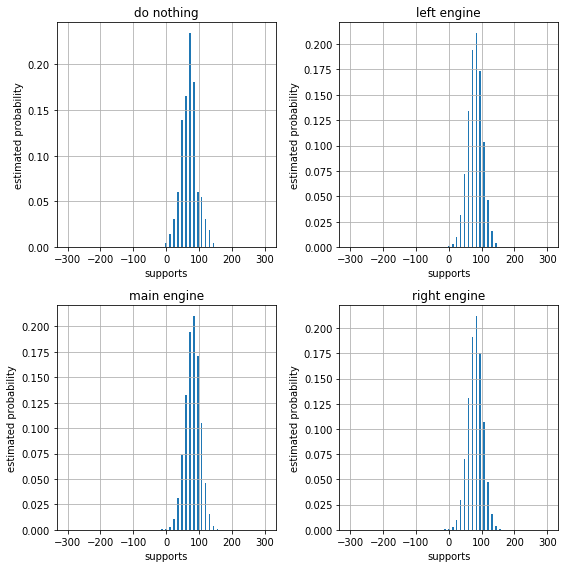

In [12]:
action = reset_env()

nothing
True
100.00330255422504


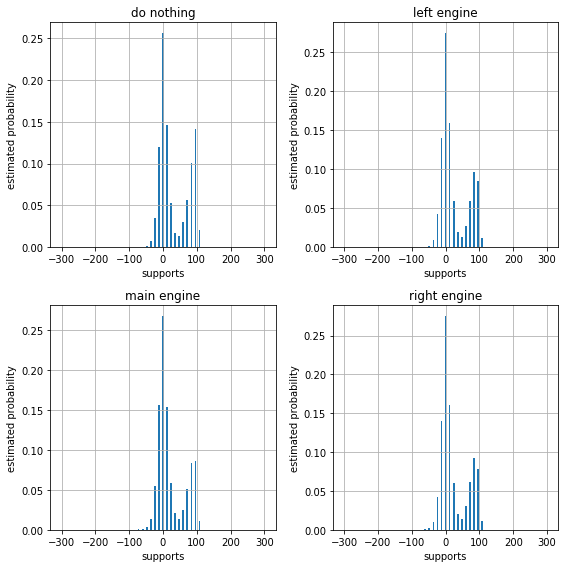

In [19]:
action = step(action, 25)

In [20]:
env.close()

---